# Advent of Code 2018

## Day 23: Experimental Emergency Teleportation

https://adventofcode.com/2018/day/23

The device lists the X,Y,Z position (pos) for each nanobot as well as its signal radius (r) on its tiny screen (your puzzle input).

Each nanobot can transmit signals to any integer coordinate which is a distance away from it less than or equal to its signal radius (as measured by Manhattan distance). Coordinates a distance away of less than or equal to a nanobot's signal radius are said to be in range of that nanobot.

In [61]:
(require racket)

In [62]:
(define data (file->lines "data/input2018-23.data"))

Bots are defined by 4 numbers: `pos = (x, y, z)` and `radius = r`. We pick those out using a regex.

In [63]:
(define bots (for/list ([line (in-list data)])
  (map string->number (regexp-match* #px"-?\\d+" line))))

First we need to find the bot with the largest radius.

In [64]:
(define maxbot (argmax fourth bots))

In [65]:
maxbot

'(111065464 50564443 49393516 99063240)

### Part 1: count number of bots within range of maxbot

We measure range as manhattan distance between bot positions. If the manhattan distance between a bot and maxbot is less than or equal to maxbot's radius, it's in range.

In [66]:
(define (distance bot-a max-bot)
  (+ (abs (- (first bot-a) (first max-bot)))
     (abs (- (second bot-a) (second max-bot)))
     (abs (- (third bot-a) (third max-bot)))))

In [67]:
(define part1 (for/sum ([bot (in-list bots)] #:when (<= (distance bot maxbot) (fourth maxbot))) 1))

In [68]:
(require rackunit)

In [69]:
(check-eq? part1 704)

Looks good -- one more gold star.

### Part 2: find the point in range of the most bots

Find the coordinates that are in range of the largest number of nanobots. What is the shortest manhattan distance between any of those points and 0,0,0?

This is a difficult problem with an elegant, fast solution (or filthy hack, delete as appropriate). It requires some insight into the data set.

The brute-force search isn't tractable. For every point (x, y, z), we'd need to calculate every bot's distance. However, if we investigate the data set, it becomes clear that almost all bots overlap. We can reduce the dimensionality of the search space by projecting onto 1-D, and finding the point(s) with the most overlap. 

This approach isn't guaranteed to produce the correct answer for every possible data set, but exploits a quirk: most of the bots are nested.

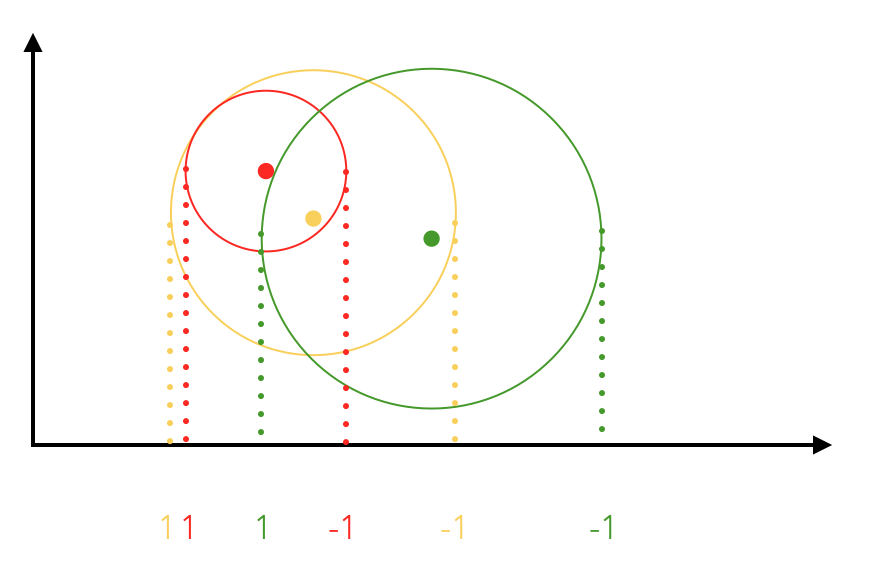

So the solution goes:

1. Reduce each bot to two points, d-r and d+r, where d is the distance from the origin and r the bot radius
2. Create an ordered list based on these two points for each bot, where the ordering is the distance from the origin, and the list entry is 1 for the "start" of the bot (d-r), and -1 for the "end" of the bot it's -1.
3. If we now find the max sum along this list, we find the points which are in reach of the most bots.

In [70]:
(require data/heap)

In [88]:
(define (bot-heap)
  ;; make heap, sorted on the first component of the elements
  (make-heap (lambda (a b) (<= (car a) (car b)))))

(define (dist-from-0 bot)
  ;; manhattan distance from origin
  (+ (abs (first bot)) (abs (second bot)) (abs (third bot))))

(define (project bots)
  ;; project each bot to a segment (d-r, d+r), and return an ordered list (as a heap)
  ;; of these segments based on the manhattan distance from the origin.
  (let loop ([projection (bot-heap)] [b bots])
    (cond [(null? b) projection]
          [else
            (define bot (car b))
            (define radius (fourth bot))
            (define dist (dist-from-0 bot))
    
            (heap-add! projection (cons (max 0 (- dist radius)) 1)) ; nearest point to 0
            (heap-add! projection (cons (+ dist radius 1) -1))      ; furtherst point to 0
            
            (loop projection (rest b))])))

In [91]:
(define (most-reachable hq)
  ;; keep a running sum along the queue, and look for the maximum
  (for/fold ([result 0] [count 0] [max-count 0] #:result result) 
            ([x (in-heap hq)])
    (define dist (car x))
    (define segment (cdr x))
    (define new-count (+ count segment))
    (cond [(> new-count max-count)
            (values dist new-count new-count)]   ; new leader -- save away its distance
          [else
            (values result new-count max-count)])))

In [92]:
(check-eq? (most-reachable (project bots)) 111960222)

...right answer, amazingly. 